# Robot Tool Segmentation using Branch Aggregation Attention Network

## Intoduction

Project for Machine Learning: Deep Learning.

In [1]:
# libraries
import torch
import random
import matplotlib.pyplot as plt
import numpy as np
#from tqdm.auto import tqdm
from tqdm.notebook import tqdm
#from tqdm import tqdm
import EndovisDataloader
import BBAModule
import EncoderModule
import TrainingUtils
import BAAnet
import DecoderModule


### Process Endovis 2018 Dataset

In [ ]:
# set seed for reprodicibility
def set_seed(seed):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch random seed for CPU
    torch.cuda.manual_seed(seed)  # PyTorch random seed for GPU
    torch.cuda.manual_seed_all(seed)  # PyTorch random seed for all GPUs 
    # Ensure deterministic behavior in CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# get dataloaders and display test images
seed = 42
batch_size = 8
reduce_factor = 4 # how much to reduce image size by before training
num_workers = 0 # 0 for notebooks
train_dataloader, val_dataloader, test_dataloader = EndovisDataloader.getDataloaders(batch_size, reduce_factor, num_workers,seed)

# make sure normalization is off first
# mean, std = calculate_mean_std(train_dataloader)
# print(f"Mean: {mean}, Std: {std}")

# visualize data 
# images,labels = next(iter(train_dataloader))

# n = 2
# cmap = plt.get_cmap('Paired',12)
# cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
# cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
#                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

# fig, axes = plt.subplots(n, 2, figsize=(20, 20))
# for i in range(n):  # Flatten the 2D array of axes
#     axes[i,0].imshow(images[i].permute(1, 2, 0))  
#     #axes[i,1].imshow(labels[i].permute(1, 2, 0))
#     label_img = EndovisDataloader.convert_masks_to_gray(labels[i])
#     im = axes[i,1].imshow(label_img, cmap = cmap, vmin = 0, vmax = 11) # Display the image in grayscale
#     # colorbar settings
#     cbar = fig.colorbar(im, ax=axes[i, 1], fraction=0.046, pad=0.04)
#     cbar.set_label("Segmentation Labels", fontsize=10)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels(cbar_labels)

# plt.tight_layout()
# plt.show()

--Data Information--
Actual Image Size: (1280, 1024)
Reduced Image Size: (320, 256)
Training Set Size: 1639
Validation Set Size: 596
Test Set Size: 997


In [ ]:
# DEBUGGING
encoder = EncoderModule.MobileNetV2Encoder(pretrained=True)
input = images[0:1]
label = labels[0:1]
print("x0:",input.shape)

x1,x2,x3,x4 = encoder(input)

print("x1:", x1.shape)
print("x2:", x2.shape)
print("x3:", x3.shape)
print("x4:", x4.shape)

channels = [24,32,64,160]
BBA = BBAModule.BBAModule(channels)
y1,y2,y3,y4 = BBA(x1,x2,x3,x4)

print()
print("y1:", y1.shape)
print("y2:", y2.shape)
print("y3:", y3.shape)
print("y4:", y4.shape)

model = DecoderModule.DecoderModule([24,32,64,64])
img = model(y1,y2,y3,y4)
print()
print("Decoder:", img.shape)


model_BBA = BAAnet.BAANet_BBA_Only()
out = model_BBA(input)
print()
print("BAA_Only:", out.shape)

model_full = BAAnet.BAANet()
out = model_full(input)
print()
print("BAAnet Full:", out.shape)


model_BAF = BAAnet.BAANet_BAF_Only()
out = model_full(input)
print()
print("BAF Only:", out.shape)

## Create Model and Hyperparameters


In [ ]:
# model and hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
epochs = 50
lr = 1e-4

#set_seed(seed) # set random seed
#model = BAAnet.BAANet_BBA_Only().to(device)
#model = BAAnet.BAANet().to(device)
model = BAAnet.BAANet_BAF_Only().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # Adam optimizer
criterion = TrainingUtils.DICELoss # loss function
#criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) # learning rate scheduler

cuda:0


In [4]:
# train model. Output is [epoch, training_loss, mdice, miou, mdice_robot, miou_robot]
training_outputs = []
for i in range(epochs):
    training_output = TrainingUtils.train(train_dataloader, val_dataloader, model, criterion, optimizer, scheduler, i, device)
    training_outputs.append(training_output)

205it [04:46,  1.40s/it]
75it [10:27,  8.37s/it]


Epoch 0: Training Loss = 0.9516913363562434, mDICE: 0.5870224746557323, mIoU: 0.5671966084632141 mDICE Robot: 0.19773823381986524, mIoU Robot: 0.12259303293281001


205it [04:01,  1.18s/it]


Epoch 1: Training Loss = 0.9474374181436042, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:08,  1.21s/it]


Epoch 2: Training Loss = 0.9472124447288065, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:08,  1.21s/it]


Epoch 3: Training Loss = 0.9472076295769793, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:08,  1.21s/it]


Epoch 4: Training Loss = 0.9472152576316791, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:09,  1.22s/it]
75it [10:23,  8.31s/it]


Epoch 5: Training Loss = 0.9472021728734423, mDICE: 0.5870238696107382, mIoU: 0.5672411102044624 mDICE Robot: 0.19718526296251487, mIoU Robot: 0.12128620723294398


205it [04:00,  1.17s/it]


Epoch 6: Training Loss = 0.947203430194302, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:06,  1.20s/it]


Epoch 7: Training Loss = 0.9472118826261736, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:08,  1.21s/it]


Epoch 8: Training Loss = 0.9472078898593578, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


205it [04:11,  1.23s/it]


Epoch 9: Training Loss = 0.9472018289342556, mDICE: 0, mIoU: 0 mDICE Robot: 0, mIoU Robot: 0


16it [00:20,  1.29s/it]


KeyboardInterrupt: 

In [5]:
# save model if necessary
torch.save(model.state_dict(), "model_bba.pth")

In [12]:
# load a model if necessary
model = BAAnet.BAANet_BBA_Only().to(device) # change to model you are loading
model.load_state_dict(torch.load("model.pth"))
model.eval()

c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\samee\miniconda3\envs\CUDA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\samee\AppData\Local\Temp\ipykernel_59484\429827041.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pyt

BAANet_BBA_Only(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, ker

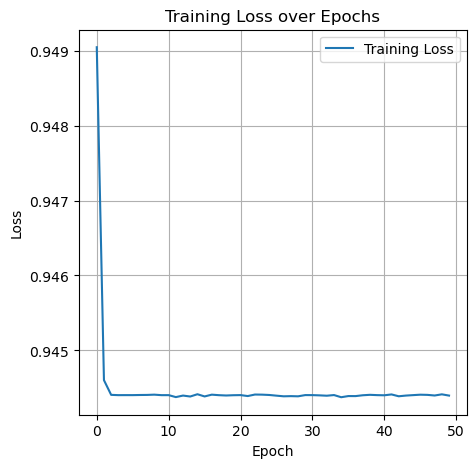

[[ 0.          0.94904417  0.58485885  0.54772881  0.62908399  0.4834095 ]
 [ 5.          0.94440472  0.59246084  0.55507866  0.63127167  0.4856421 ]
 [10.          0.94440453  0.59428661  0.55708233  0.63303136  0.48781068]
 [15.          0.94438722  0.59368868  0.55742218  0.63780695  0.49343709]
 [20.          0.94440511  0.59360031  0.55657671  0.63329752  0.48835093]
 [25.          0.94439752  0.59490212  0.55693158  0.63285083  0.48733449]
 [30.          0.94440477  0.59729913  0.55929604  0.63322961  0.48783857]
 [35.          0.94439226  0.59776104  0.55979665  0.63021878  0.48447711]
 [40.          0.94440259  0.59375853  0.55652825  0.63457769  0.48956791]
 [45.          0.94441044  0.59463785  0.55732989  0.63337881  0.48816934]]


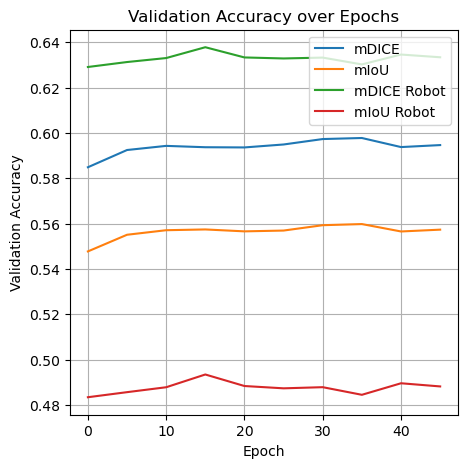

In [6]:
# process outputs 
training_outputs_cpu = []
for i in training_outputs:
    temp = []
    for j in i:
        if torch.is_tensor(j):
            temp.append(j.cpu())
        else:
            temp.append(j)
    training_outputs_cpu.append(temp)
    
training_outputs_cpu = np.array(training_outputs_cpu)

#print training loss
plt.figure(figsize=(5, 5))
plt.plot(training_outputs_cpu[:,0], training_outputs_cpu[:,1], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

#print validation scores
training_outputs_cpu_filtered = [value for index, value in enumerate(training_outputs_cpu) if index % 5 == 0]
training_outputs_cpu_filtered = np.array(training_outputs_cpu_filtered)
print(training_outputs_cpu_filtered)
plt.figure(figsize=(5, 5))
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,2], label='mDICE')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,3], label='mIoU')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,4], label='mDICE Robot')
plt.plot(training_outputs_cpu_filtered[:,0], training_outputs_cpu_filtered[:,5], label='mIoU Robot')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [7]:
# test model
m_dice, m_iou, mdice_robot, miou_robot = TrainingUtils.test(model, test_dataloader, device)
print(f"Mean DICE Score: {m_dice}")
print(f"Mean IoU Score: {m_iou}")
print(f"Mean DICE Robot Score: {mdice_robot}")
print(f"Mean IoU Robot Score: {miou_robot}")

125it [17:19,  8.31s/it]

Mean DICE Score: 0.5779660376120032
Mean IoU Score: 0.544421656098437
Mean DICE Robot Score: 0.595789888025373
Mean IoU Robot Score: 0.4661293510158125


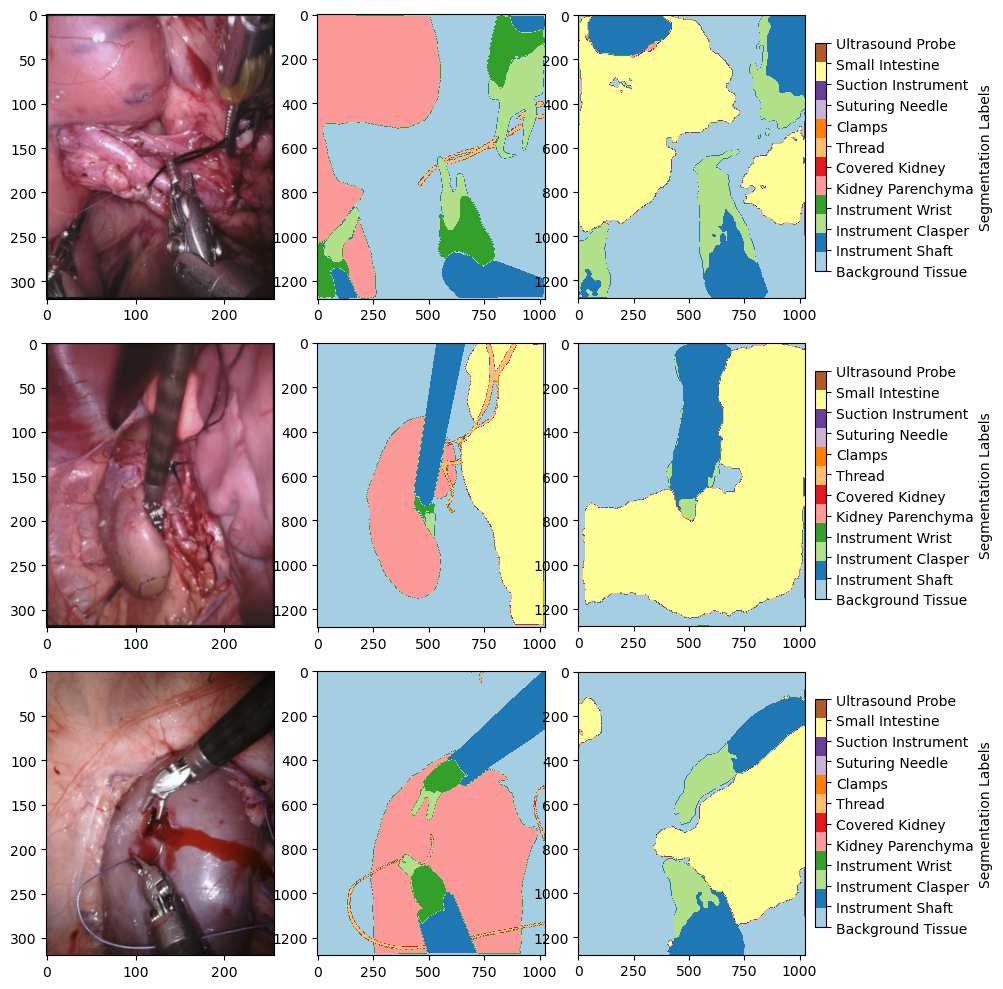

In [8]:
def get_ith_sample(dataloader, i):
    
    batch_size = dataloader.batch_size  
    batch_idx = i // batch_size         
    sample_idx = i % batch_size         

    for current_batch_idx, (images, labels) in enumerate(dataloader):
        if current_batch_idx == batch_idx:
            # Return the i-th sample from the batch
            return images[sample_idx], labels[sample_idx]

# display model outputs
model.cpu()
#i = 1 # 0 to batch_size
# pick 3 "random" images to compare models on
imgs, labels = [], []
img1, lab1 = get_ith_sample(val_dataloader, 198)
img2, lab2 = get_ith_sample(val_dataloader, 271)
img3, lab3 = get_ith_sample(test_dataloader, 159)
imgs = [img1, img2, img3]
labels = [lab1, lab2, lab3]
results = []

for i in range(3):
    input, label = imgs[i].unsqueeze(0), labels[i].unsqueeze(0)

    predict = model(input) # predict image
    predict = torch.argmax(predict, dim=1) # get grayscale prediction
    predict = torch.eye(12, device=predict.device)[predict].permute(0,3,1,2)
    predict = torch.nn.functional.interpolate(predict.float(), size=label.shape[2:], mode="nearest-exact")  # match label size
    prediction = EndovisDataloader.convert_masks_to_gray(predict.squeeze(0))

    label = EndovisDataloader.convert_masks_to_gray(label.squeeze(0))

    cmap = plt.get_cmap('Paired',12)
    cbar_ticks = [0,1,2,3,4,5,6,7,8,9,10,11]
    cbar_labels = ["Background Tissue", "Instrument Shaft", "Instrument Clasper", "Instrument Wrist", "Kidney Parenchyma", "Covered Kidney", 
                "Thread", "Clamps", "Suturing Needle", "Suction Instrument", "Small Intestine", "Ultrasound Probe"]

    # un-normalize input
    mean = torch.tensor([0.464, 0.341, 0.363]).view(-1, 1, 1)
    std = torch.tensor([0.210, 0.194, 0.204]).view(-1, 1, 1)
    input = input.squeeze(0) * std + mean

    results.append((input,label,prediction))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    axes[i,0].imshow(results[i][0].permute(1, 2, 0))
    axes[i,1].imshow(results[i][1], cmap = cmap, vmin = 0, vmax = 11)
    im = axes[i,2].imshow(results[i][2], cmap = cmap, vmin = 0, vmax = 11)

    cbar = fig.colorbar(im, ax=axes[i,2], fraction=0.046, pad=0.04)
    cbar.set_label("Segmentation Labels", fontsize=10)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_labels)


plt.tight_layout()
plt.show()

# things to record: epochs, batch_size, reduce_factor, training loss curve, training time, validation score curves, test scores, test time, example image (below)